# RNN Time Series for Ford Predictions

In [1]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
import sklearn.preprocessing
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
import quandl


/Users/omsoni/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
quandl.ApiConfig.api_key = "EodKRXnzq6S5xDQy1ZBQ"

In [3]:
from pandas import Series
def parser(x):
    return pd.to_datetime(x, format='%Y-%m-%d')
FSdata = pd.read_csv('F.csv',  header=0 , parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

FSdata.info()
FSdata.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11556 entries, 2018-03-27 to 1972-06-01
Data columns (total 12 columns):
Open           11556 non-null float64
High           11556 non-null float64
Low            11556 non-null float64
Close          11556 non-null float64
Volume         11556 non-null float64
Ex-Dividend    11556 non-null float64
Split Ratio    11556 non-null float64
Adj. Open      11556 non-null float64
Adj. High      11556 non-null float64
Adj. Low       11556 non-null float64
Adj. Close     11556 non-null float64
Adj. Volume    11556 non-null float64
dtypes: float64(12)
memory usage: 1.1 MB


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-27,10.85,10.920,10.72,10.83,38263798.0,0.0,1.0,10.85,10.920,10.72,10.83,38263798.0
2018-03-26,10.74,10.870,10.68,10.83,52165572.0,0.0,1.0,10.74,10.870,10.68,10.83,52165572.0
2018-03-23,10.79,10.850,10.51,10.56,39706214.0,0.0,1.0,10.79,10.850,10.51,10.56,39706214.0
2018-03-22,11.00,11.060,10.73,10.75,50907549.0,0.0,1.0,11.00,11.060,10.73,10.75,50907549.0
2018-03-21,11.00,11.185,10.93,11.10,38407514.0,0.0,1.0,11.00,11.185,10.93,11.10,38407514.0


In [4]:
FSdata.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1972-06-07,65.50,65.88,65.13,65.13,38011.0,0.0,1.0,0.700653,0.704718,0.696695,0.696695,6.717969e+05
1972-06-06,66.25,66.50,65.25,65.50,80424.0,0.0,1.0,0.708676,0.711350,0.697979,0.700653,1.421394e+06
1972-06-05,66.25,66.88,66.00,66.25,294680.0,0.0,1.0,0.708676,0.715415,0.706002,0.708676,5.208101e+06
1972-06-02,66.38,67.00,66.00,66.25,66398.0,0.0,1.0,0.710067,0.716699,0.706002,0.708676,1.173502e+06
1972-06-01,66.91,67.00,66.25,66.38,61628.0,0.0,1.0,0.715736,0.716699,0.708676,0.710067,1.089198e+06


In [5]:
FSdata.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,11556.000000,11556.000000,11556.000000,11556.000000,1.155600e+04,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,1.155600e+04
mean,32.739338,33.107349,32.345927,32.733942,1.573808e+07,0.005235,1.000331,5.820577,5.893862,5.739832,5.815397,1.849650e+07
std,20.194938,20.397186,19.986312,20.203149,2.896111e+07,0.218329,0.015807,5.142907,5.208395,5.075405,5.139778,2.791219e+07
min,1.310000,1.550000,1.010000,1.260000,3.236000e+03,0.000000,1.000000,0.212335,0.213940,0.210597,0.212335,5.719225e+04
25%,13.810000,13.950000,13.610000,13.780000,7.123060e+05,0.000000,1.000000,0.779410,0.790528,0.769783,0.779677,4.062800e+06
50%,31.370000,31.870000,31.000000,31.370000,3.228167e+06,0.000000,1.000000,4.713731,4.782013,4.642609,4.713472,7.920698e+06
75%,47.500000,48.000000,46.870000,47.500000,2.074689e+07,0.000000,1.000000,10.050781,10.157418,9.901215,10.037736,2.246316e+07
max,112.000000,112.620000,110.750000,111.630000,5.411756e+08,22.468000,2.000000,20.663430,20.933236,20.015508,20.682038,5.411756e+08


In [6]:
# function for min-max normalization of stock
def normalize(fs):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    fs['Open'] = min_max_scaler.fit_transform(fs.Open.values.reshape(-1,1))
    fs['High'] = min_max_scaler.fit_transform(fs.High.values.reshape(-1,1))
    fs['Low'] = min_max_scaler.fit_transform(fs.Low.values.reshape(-1,1))
    fs['Close'] = min_max_scaler.fit_transform(fs.Close.values.reshape(-1,1))
    return fs

In [7]:
print("Avaiable predictors")
print(FSdata.columns.values)
dataset = FSdata.loc[:,('Open', 'Low' , 'High' ,'Close')]
print("Selected predictors")
print(dataset.columns.values)
normFS = normalize(dataset)

Avaiable predictors
['Open' 'High' 'Low' 'Close' 'Volume' 'Ex-Dividend' 'Split Ratio'
 'Adj. Open' 'Adj. High' 'Adj. Low' 'Adj. Close' 'Adj. Volume']
Selected predictors
['Open' 'Low' 'High' 'Close']


In [8]:
def plotData(data):
    plt.figure(figsize=(15, 5));
    plt.plot(data.Open.values, color='red', label='open')
    plt.plot(data.Close.values, color='green', label='Close')
    plt.plot(data.Low.values, color='blue', label='Low')
    plt.plot(data.High.values, color='black', label='high')
    plt.title('Ford stock')
    plt.xlabel('time [in days]')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()

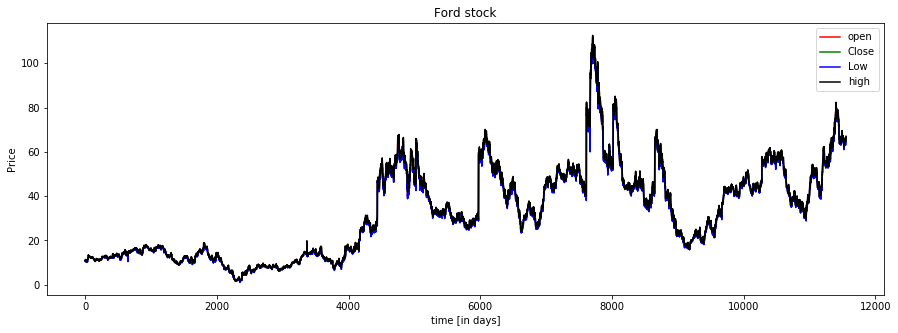

In [9]:
plotData(FSdata)

#### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model.  

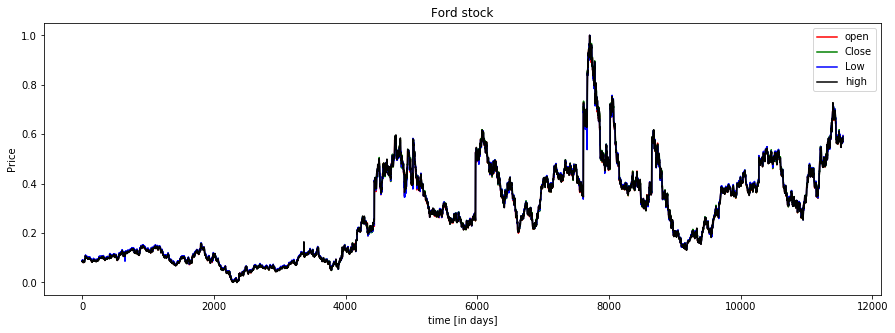

In [10]:
plotData(normFS)

In [11]:
def prepare_datasets(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


In [12]:
seq_len = 20 # choose sequence length
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
x_train, y_train, x_valid, y_valid, x_test, y_test = prepare_datasets(normFS, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (9228, 19, 4)
y_train.shape =  (9228, 4)
x_valid.shape =  (1154, 19, 4)
y_valid.shape =  (1154, 4)
x_test.shape =  (1154, 19, 4)
y_test.shape =  (1154, 4)


In [13]:
print(x_train[1,:])
print("-----------------------------\n\n\n")
print(x_train[2,:])

[[0.08519288 0.08811737 0.08391105 0.08670834]
 [0.08564459 0.08656825 0.08373098 0.08426203]
 [0.08754178 0.08857299 0.08562168 0.08598351]
 [0.08754178 0.09039548 0.0867471  0.08915466]
 [0.0879935  0.09075998 0.08625191 0.08815801]
 [0.08889692 0.08984873 0.08661205 0.08833922]
 [0.08862589 0.0915801  0.08706221 0.08960768]
 [0.0879935  0.09057773 0.08733231 0.08888285]
 [0.08980034 0.09112448 0.08904295 0.08842983]
 [0.0860963  0.08857299 0.08490141 0.08625532]
 [0.08474117 0.08811737 0.08373098 0.08652714]
 [0.08419911 0.087115   0.08265058 0.0858023 ]
 [0.0843798  0.08629488 0.08220041 0.08471505]
 [0.08311501 0.08583926 0.08184028 0.08489626]
 [0.0843798  0.08620375 0.08220041 0.08489626]
 [0.08130816 0.08465464 0.08175025 0.08444324]
 [0.08067576 0.08319665 0.07985955 0.08281236]
 [0.0843798  0.08374339 0.08229045 0.08181571]
 [0.08465083 0.087115   0.08319078 0.08471505]]
-----------------------------



[[0.08564459 0.08656825 0.08373098 0.08426203]
 [0.08754178 0.08857299 0.

In [14]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [15]:
# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 10 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [32]:
def buildRNN(layers):
    with tf.variable_scope("training_op", reuse=tf.AUTO_REUSE):
        multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
        rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

        stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
        stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
        outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
        outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

        loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
        training_op = optimizer.minimize(loss)
        return training_op 

In [36]:
def runGraph():
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        for iteration in range(int(n_epochs*train_set_size/batch_size)):
            x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
            sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
            if iteration % int(5*train_set_size/batch_size) == 0:
                mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
                mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
                print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                    iteration*batch_size/train_set_size, mse_train, mse_valid))
        y_train_pred = sess.run(outputs, feed_dict={X: x_train})
        y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
        y_test_pred = sess.run(outputs, feed_dict={X: x_test})

In [37]:
# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
buildRNN(layers)

<tf.Operation 'training_op_5/Adam' type=NoOp>

In [38]:
runGraph()

NameError: name 'loss' is not defined

In [ ]:
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
training_op = buildRNN(layers)
runGraph(training_op)

In [ ]:
# use Basic LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
training_op = buildRNN(layers)
runGraph(training_op)

In [ ]:
# use LSTM Cell with peephole connections
layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
                                  activation=tf.nn.leaky_relu, use_peepholes = True)
          for layer in range(n_layers)]
training_op = buildRNN(layers)
runGraph(training_op)

In [ ]:
# use GRU cell
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
          for layer in range(n_layers)]
training_op = buildRNN(layers)
runGraph(training_op)

In [ ]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [ ]:
plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))